# 1. 라이브러리 불러오기

In [1]:
import numpy as np
np.float_ = np.float64
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

from prophet import Prophet
import warnings
warnings.filterwarnings('ignore')

c:\Users\Jaesik\miniconda3\envs\lenovo\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 맷플롯립 한글 설정 
# matplotlib Korean font
plt.rc('font', family='Malgun Gothic')

# 모든 컬럼을 표시하도록 설정
pd.set_option('display.max_columns', None)

# 컬럼의 너비 제한 해제
pd.set_option('display.max_colwidth', None)

# 출력할 행의 수를 설정 (필요에 따라 조정)
pd.set_option('display.max_rows', 300)

plt.rcParams['axes.unicode_minus'] = False

# 2. 데이터 로드

In [3]:
# 공실률 데이터 로드
master_sanga_bld = gpd.read_file('00data/102.상가_공실률.geojson')
master_sanga_bld.shape

(89232, 31)

In [4]:
# 필요없는 열 제거
df = master_sanga_bld[['date', 'vacancy_rat']]

# 형식 변경
df['date'] = pd.to_datetime(df['date'])

df

,date,vacancy_rat
0,2012-07-01,NaN
1,2012-08-01,NaN
2,2012-09-01,NaN
3,2012-10-01,NaN
4,2012-11-01,NaN
...,...,...
89227,2024-01-01,20.340624
89228,2024-02-01,20.340624
89229,2024-03-01,19.548774
89230,2024-04-01,18.885426


In [5]:
# 시계열 데이터로 변환
df = df.groupby('date').mean().reset_index()
df.head()

,date,vacancy_rat
0,2012-07-01,16.400106
1,2012-08-01,15.950728
2,2012-09-01,15.615723
3,2012-10-01,15.174682
4,2012-11-01,14.842015


In [6]:
# make a date column for prophet till 2025-12-01

# 2025-12-01까지의 날짜를 생성
future = pd.date_range(start='2024-06-01', end='2025-12-01', freq='MS')

# df의 date 컬럼 밑으로 future를 추가
# df = pd.concat([df, pd.DataFrame({'date': future})], axis=0)

df_date_index = df.copy()
# df의 date열을 인덱스로 설정
df_date_index = df_date_index.set_index('date')
df_date_index.head()

,vacancy_rat
date,
2012-07-01,16.400106
2012-08-01,15.950728
2012-09-01,15.615723
2012-10-01,15.174682
2012-11-01,14.842015


# 3. 시계열 예측

## 3.1. 시각화

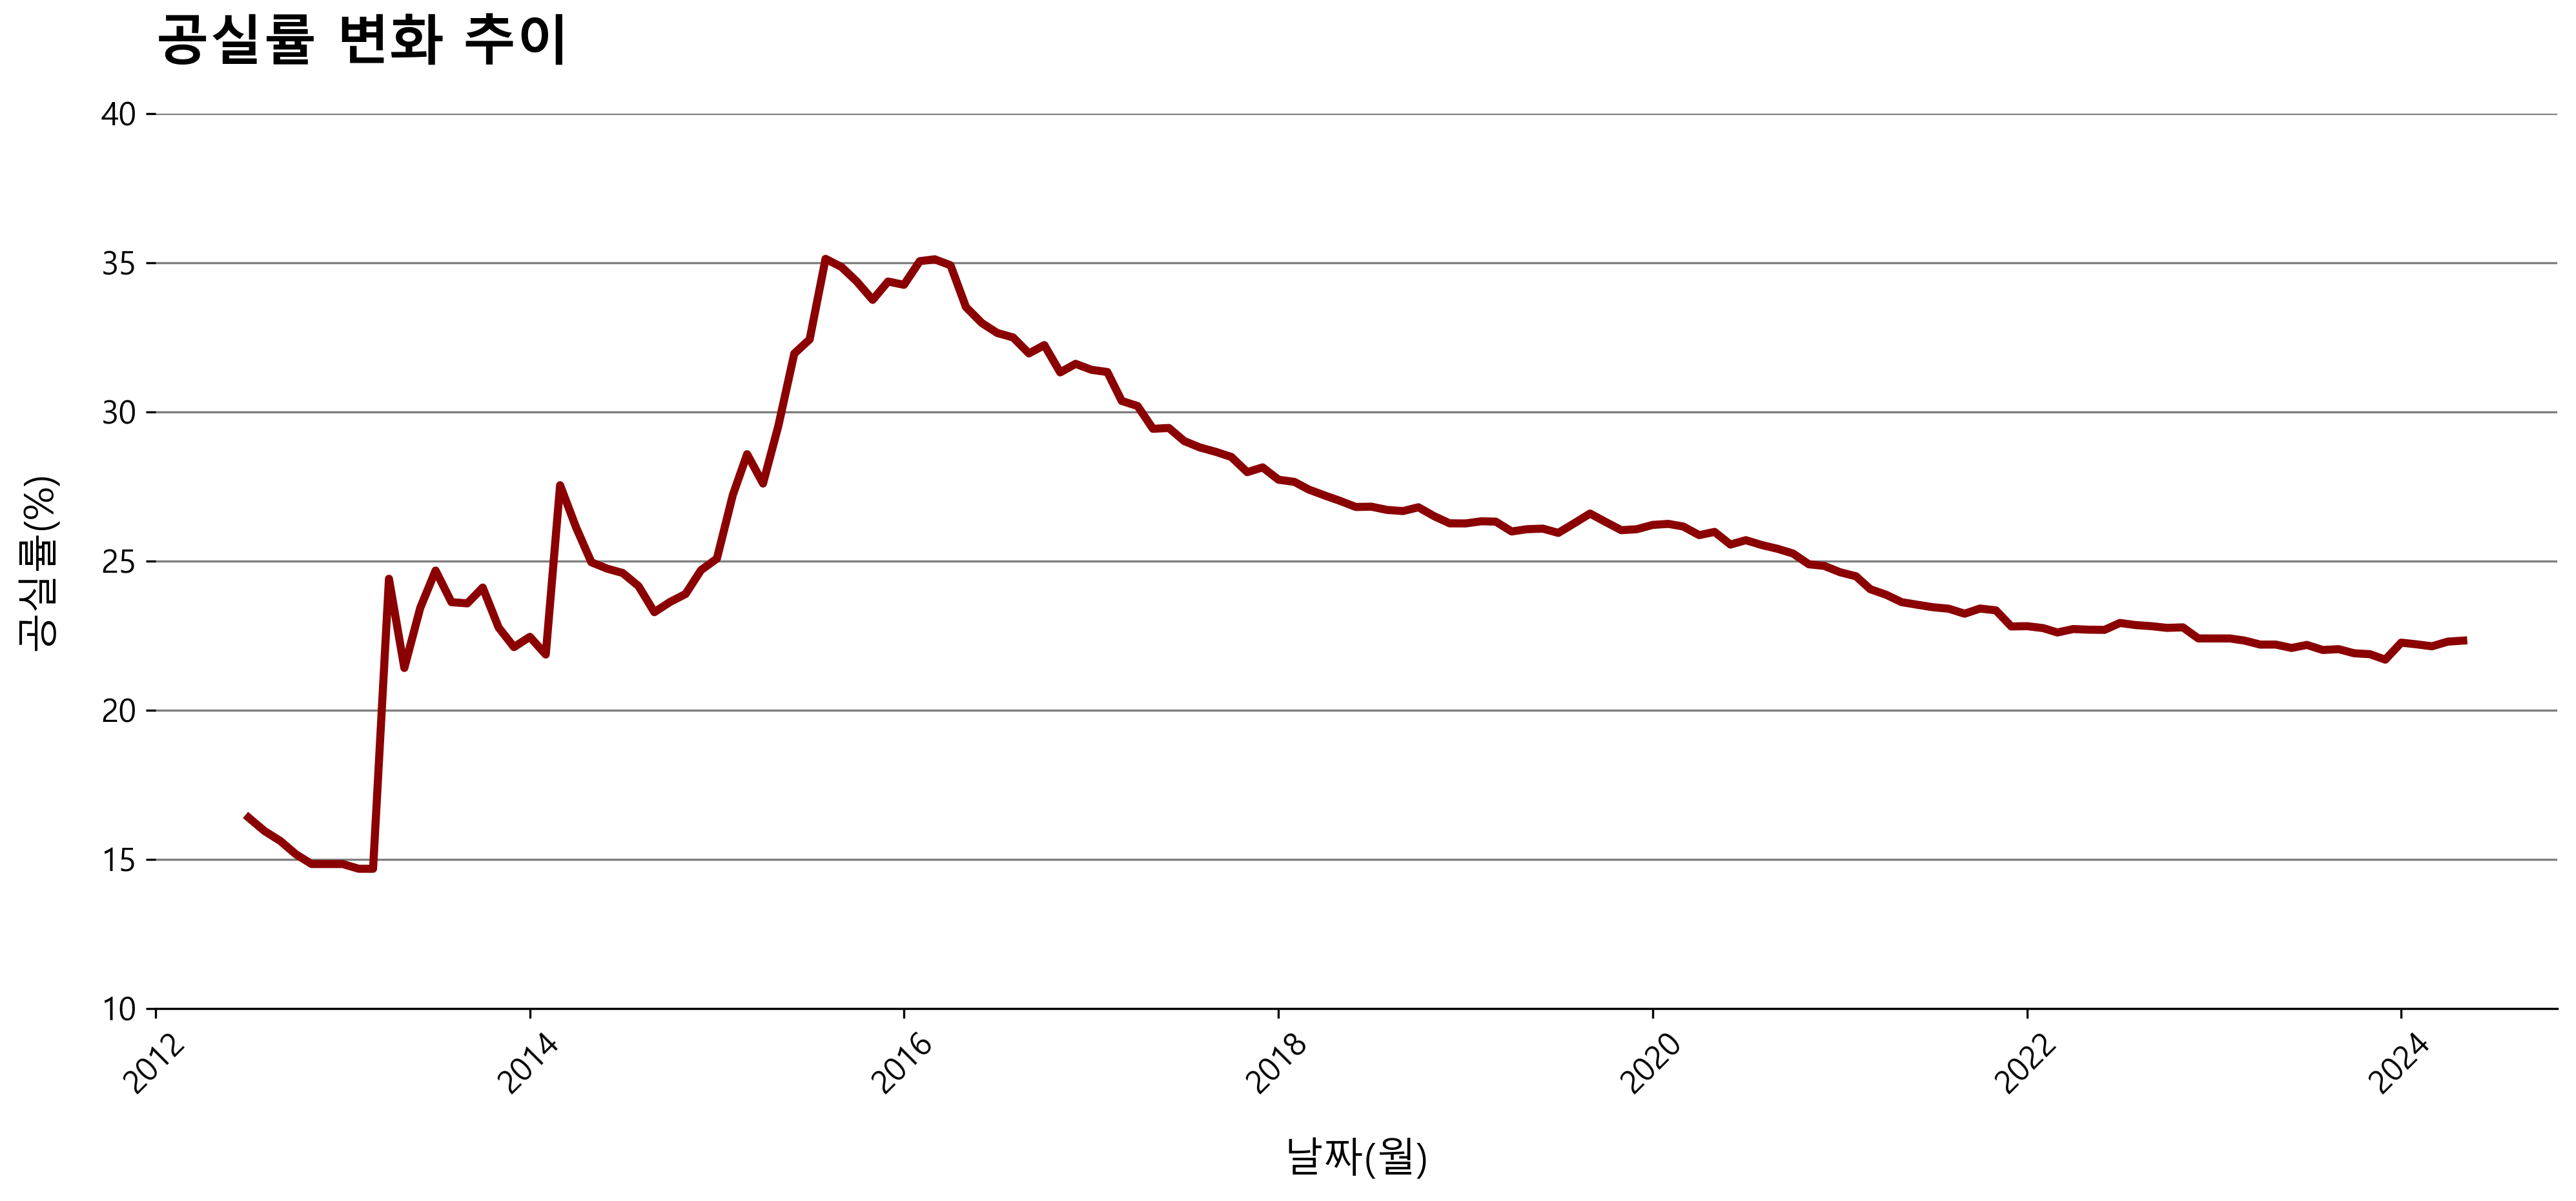

In [7]:
# 기본 공실률 현황 

from datetime import datetime


start_date = datetime.strptime('2012-01-01', '%Y-%m-%d')
end_date = datetime.strptime('2024-10-31', '%Y-%m-%d')

plt.figure(figsize=(16, 6), dpi=300)
plt.plot(df_date_index.index, df_date_index['vacancy_rat'], linewidth = 3 ,color='darkred')
plt.title('공실률 변화 추이', loc='left', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('날짜(월)', fontsize=15, labelpad=15)
plt.ylabel('공실률(%)', fontsize=15, labelpad=15)
plt.xlim( start_date, end_date)

# 좌측과 상단의 테두리 선 제거
ax = plt.gca()  # 현재 축 객체 가져오기
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# 그리드를 가로선만
plt.grid(axis='y', color='black', alpha=0.5)

plt.ylim(10, 40)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

plt.show()

## 3.2. ARIMA

In [8]:
from statsmodels.tsa.arima.model import ARIMA

# ARIMA 모델 적용
arima_model = ARIMA(df['vacancy_rat'], order=(10, 1, 5)) # (p, d, q) : 
# p: 자기회귀 차수AR  이전 값들의 회귀로 설명할 수 있는 시차의 개수
# d: 차분 차수,I - 차분을 몇 번 수행할지 
# q: 이동 평균 차수, MA - 이전 예측 오차들의 가중 평균으로 예측하는 시차의 개수
arima_fit = arima_model.fit()

# 2025년 12월까지 예측
arima_forecast = arima_fit.get_forecast(steps=19)  # 2024-06 ~ 2025-12 (19 months)
arima_forecast_df = arima_forecast.summary_frame()


c:\Users\Jaesik\miniconda3\envs\lenovo\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


**변수 설명**
|mean | 데이터의 평균값.|
|----|----|
|mean_se| 평균의 표준 오차, 평균값의 추정에 대한 불확실성.|
|mean_ci_lower| 평균에 대한 신뢰 구간의 하한값.|
|mean_ci_upper| 평균에 대한 신뢰 구간의 상한값.|


In [9]:
# df에 예측값 추가
# 1. arima_forcast_df에서 예측값만 추출하고 인덱스를 future로 설정
# 2. df와 arima_forcast_df를 병합

arima_forecast_df_concat = arima_forecast_df[['mean', 'mean_ci_lower', 'mean_ci_upper']]
arima_forecast_df_concat.index = future
arima_forecast_df_concat.rename(columns={'mean': 'vacancy_rat'}, inplace=True)
arima_forecast_df_concat


vacancy_rat,vacancy_rat,mean_ci_lower,mean_ci_upper
2024-06-01,22.373805,20.479252,24.268359
2024-07-01,22.363302,19.750710,24.975895
2024-08-01,22.474959,19.111491,25.838427
2024-09-01,22.471461,18.423793,26.519129
2024-10-01,22.586427,17.971878,27.200976
2024-11-01,22.347745,17.275843,27.419646
2024-12-01,22.602317,17.011092,28.193541
2025-01-01,22.608847,16.527093,28.690601
2025-02-01,22.459861,15.881166,29.038557
2025-03-01,22.579884,15.457869,29.701900


### 3.2.1. ARIMA 시각화

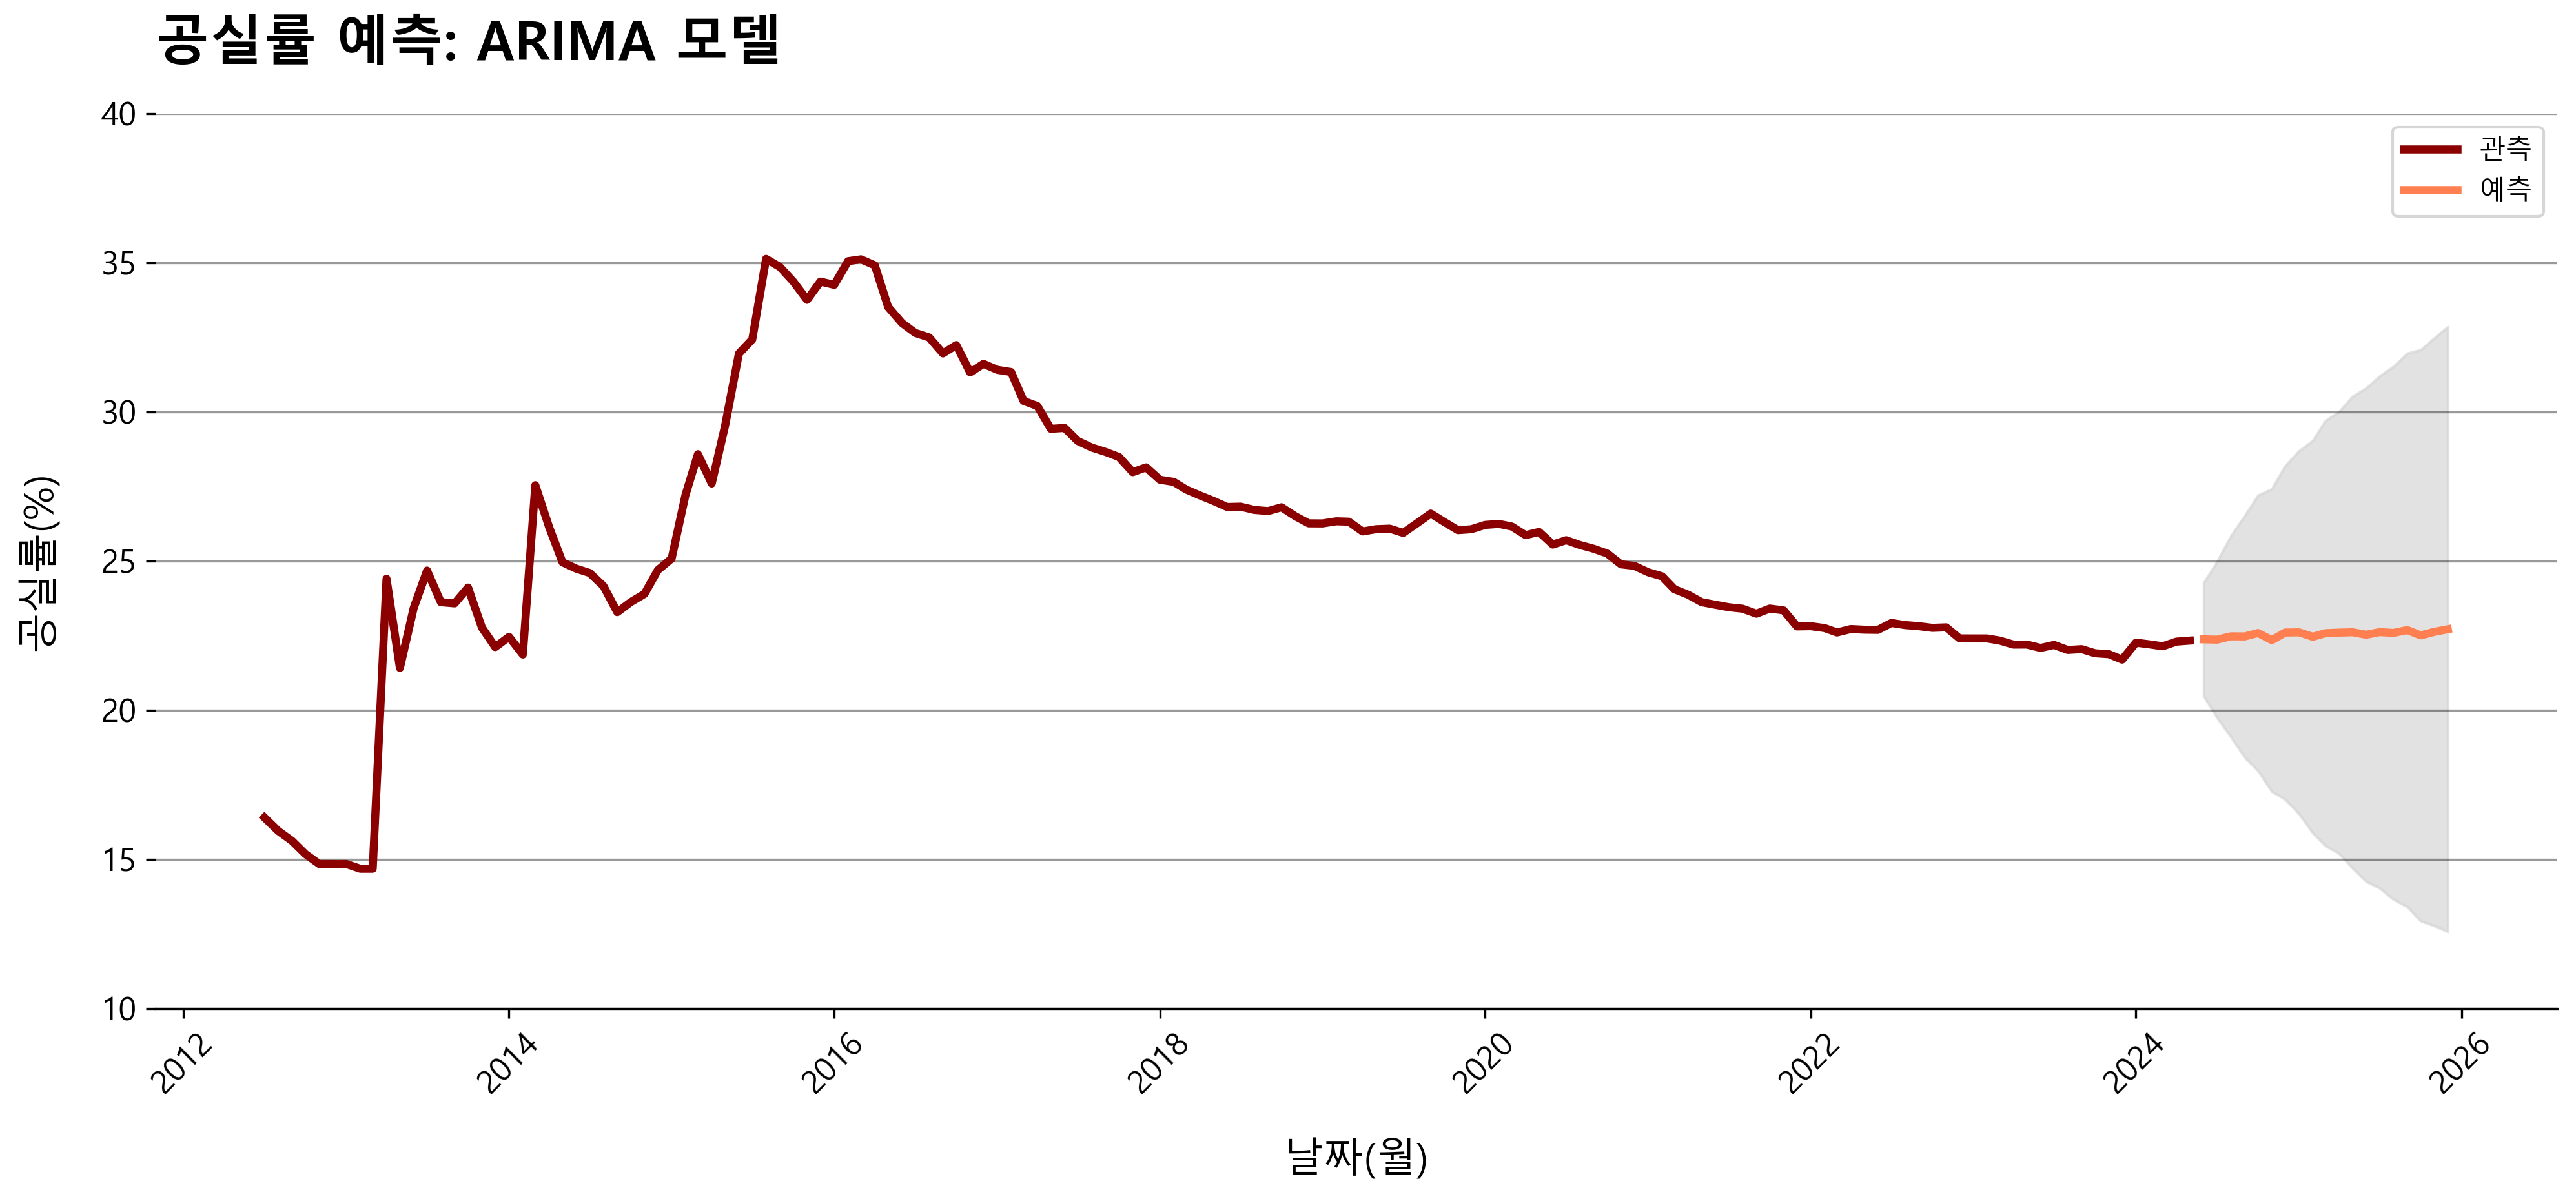

In [11]:

plt.figure(figsize=(16, 6), dpi=300)
plt.plot(df_date_index.index, df_date_index['vacancy_rat'],  linewidth=3, color='darkred', label='관측')
# 신뢰구간 시각화
plt.fill_between(arima_forecast_df_concat.index, arima_forecast_df_concat['mean_ci_lower'], arima_forecast_df_concat['mean_ci_upper'], color='lightgray', alpha=0.65)
# 예측값 시각화
plt.plot(arima_forecast_df_concat.index, arima_forecast_df_concat['vacancy_rat'], linewidth=3, color='coral', label='예측',  zorder=10)


plt.title('공실률 예측: ARIMA 모델', loc='left', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('날짜(월)', fontsize=15, labelpad=15)
plt.ylabel('공실률(%)', fontsize=15, labelpad=15)

# 좌측과 상단의 테두리 선 제거
ax = plt.gca()  # 현재 축 객체 가져오기
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# 그리드를 가로선만
plt.grid(axis='y', color='black', alpha=0.4)

plt.ylim(10, 40)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

plt.legend()
plt.show()

## 3.3. SARIMA

**작동방식 정리**
1. order 매개변수 (p, d, q) 
- ARIMA와 동일
2. seasonal_order 매개변수 (P, D, Q, s)
- P (계절적 자기회귀 차수, Seasonal AR): 시계열의 계절적 패턴에 대한 자기회귀 차수를 나타냄
- D (계절적 차분 차수, Seasonal I): 계절적 차분의 횟수
- Q (계절적 이동 평균 차수, Seasonal MA): 계절적 패턴에서 과거의 예측 오차에 대한 의존성을 나타냄
- s (계절 주기, Seasonal Periodicity): 계절성이 반복되는 주기를 나타냄

In [12]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# SARIMA 모델 적용
sarima_model = SARIMAX(df['vacancy_rat'], order=(10,1,5), seasonal_order=(1, 1, 1, 12))
sarima_fit = sarima_model.fit(disp=False)

# 2025년 12월까지 예측
sarima_forecast = sarima_fit.get_forecast(steps=19)  # 2024-06 ~ 2025-12 (19 months)
sarima_forecast_df = sarima_forecast.summary_frame()
sarima_forecast_df.index = future


# 예측 결과 출력
sarima_forecast_df


c:\Users\Jaesik\miniconda3\envs\lenovo\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


vacancy_rat,mean,mean_se,mean_ci_lower,mean_ci_upper
2024-06-01,22.406534,1.045717,20.356966,24.456103
2024-07-01,22.452107,1.393053,19.721774,25.182441
2024-08-01,22.509297,1.764084,19.051756,25.966838
2024-09-01,22.400520,2.138548,18.209043,26.591997
2024-10-01,22.550603,2.420777,17.805968,27.295238
2024-11-01,22.203773,2.654707,17.000643,27.406902
2024-12-01,22.192498,2.988082,16.335964,28.049032
2025-01-01,22.341336,3.309604,15.854632,28.828040
2025-02-01,22.230023,3.602405,15.169438,29.290607
2025-03-01,22.244379,3.900718,14.599113,29.889645


### 3.3.1. SARIMA 시각화

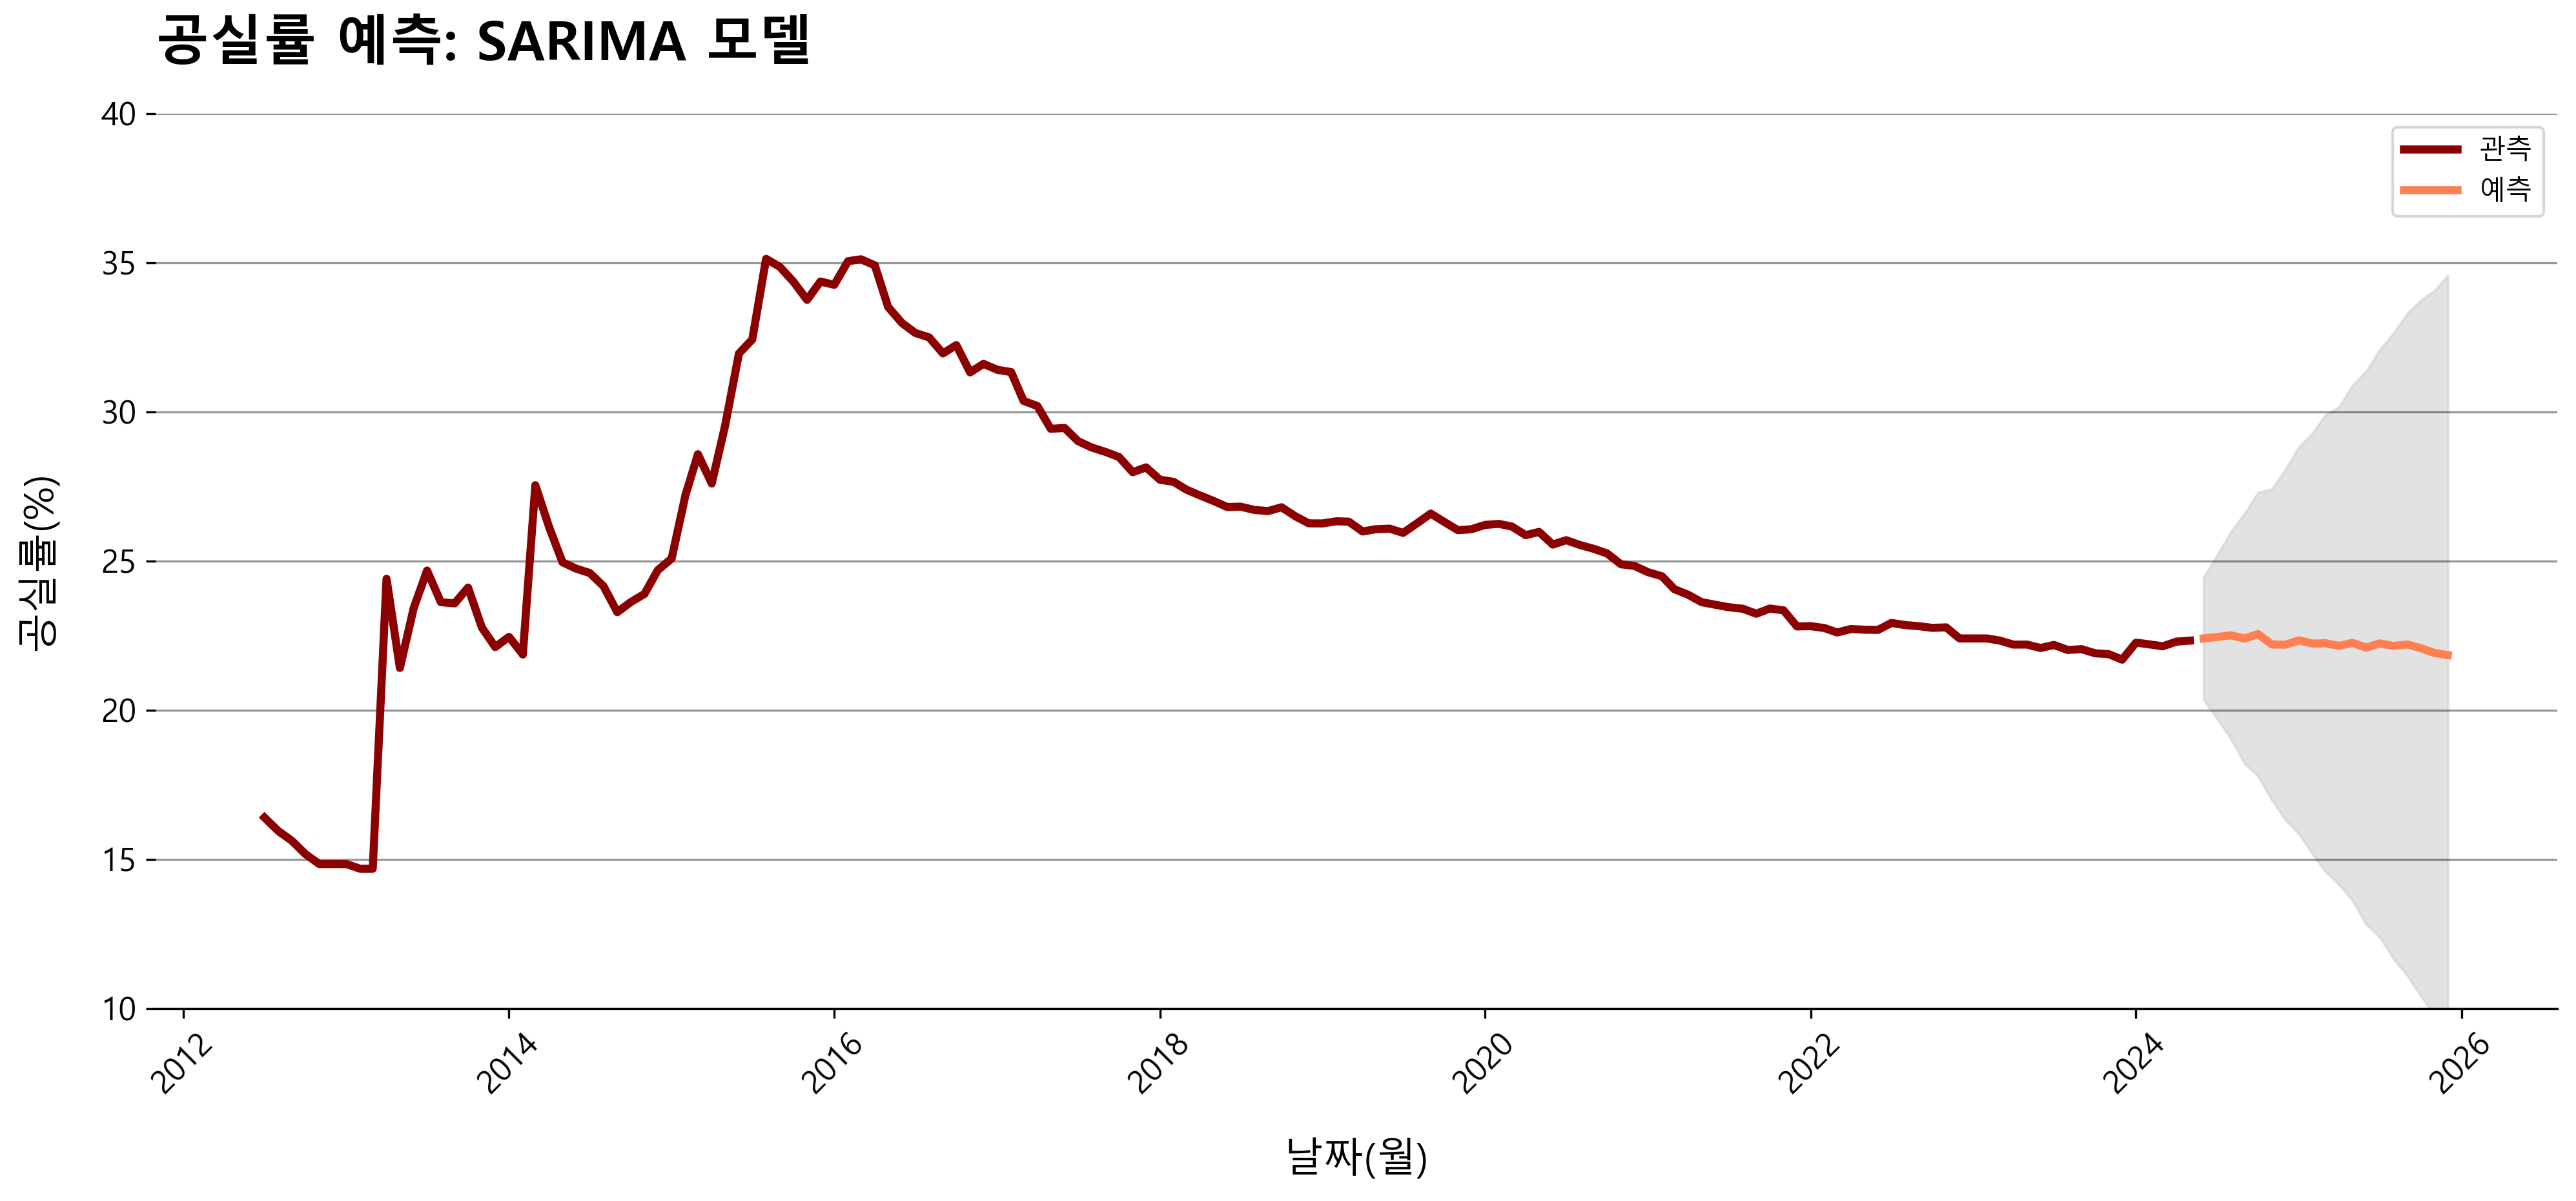

In [13]:
# 예측 결과 시각화
plt.figure(figsize=(16, 6), dpi=300)
plt.plot(df_date_index.index, df_date_index['vacancy_rat'], label='관측', color='darkred', linewidth=3)
plt.plot(sarima_forecast_df.index, sarima_forecast_df['mean'], label='예측', color='coral', linewidth=3)
plt.fill_between(sarima_forecast_df.index, sarima_forecast_df['mean_ci_lower'], sarima_forecast_df['mean_ci_upper'], color='lightgray', alpha=0.65)

# x축 눈금 설정 (매월 표시)
# plt.xticks(pd.date_range(start='2020-01-01', end='2025-12-31', freq='MS'), rotation=45)
# plt.xticks(pd.date_range(start='2025-01-01', end='2025-12-31', freq='M'), rotation=45)

plt.title('공실률 예측: SARIMA 모델', loc='left', fontsize=20, fontweight='bold', pad=20)
plt.xlabel('날짜(월)', fontsize=15, labelpad=15)
plt.ylabel('공실률(%)', fontsize=15, labelpad=15)

# 좌측과 상단의 테두리 선 제거
ax = plt.gca()  # 현재 축 객체 가져오기
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# 그리드를 가로선만
plt.grid(axis='y', color='black', alpha=0.4)

plt.ylim(10, 40)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

plt.legend()
plt.show()

## 3.4. Prophet

In [20]:
# prophet 용 df 생성
df_prophet = df.reset_index(drop=True)
df_prophet = df_prophet.rename(columns={'date': 'ds', 'vacancy_rat': 'y'})

df_prophet.head()

,ds,y
0,2012-07-01,16.400106
1,2012-08-01,15.950728
2,2012-09-01,15.615723
3,2012-10-01,15.174682
4,2012-11-01,14.842015


In [21]:
# Prophet 모델 적용

prophet_model = Prophet()
prophet_model.fit(df_prophet)

21:36:26 - cmdstanpy - INFO - Chain [1] start processing
21:36:26 - cmdstanpy - INFO - Chain [1] done processing


In [22]:
# 2025년 12월까지 예측
future_dates = prophet_model.make_future_dataframe(periods=19, freq='MS')  # 2024-06 ~ 2025-12 (19 months)
forecast = prophet_model.predict(future_dates)

In [23]:
# concating the result into df_concat
prophet_forecast_df = forecast[['ds', 'yhat']].set_index('ds')
prophet_forecast_df = prophet_forecast_df.iloc[-19:]



In [31]:
# 예측 결과 합치기
arima_df = arima_forecast_df_concat['vacancy_rat']
sarima_df = sarima_forecast_df['mean']

arima_bros = pd.merge(arima_df, sarima_df, left_index=True, right_index=True)

predicted_df = pd.merge(arima_bros, prophet_forecast_df, left_index=True, right_index=True)
predicted_df.columns = ['ARIMA', 'SARIMA', 'Prophet']

predicted_df = pd.concat([df_date_index, predicted_df])
predicted_df.to_csv('01outputdata/공실률_추이_및_예측.csv')

### 3.4.1. Prophet 시각화

<Figure size 4800x1800 with 0 Axes>

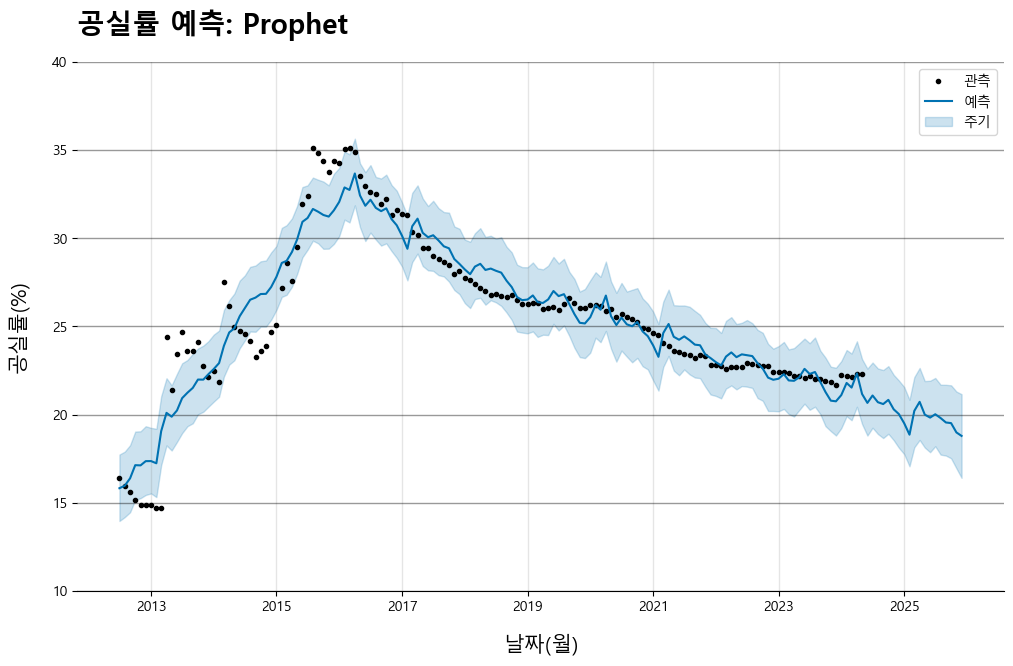

In [48]:
plt.figure(figsize=(16, 6), dpi=300)
fig = prophet_model.plot(forecast)
plt.title('공실률 예측: Prophet', loc='left', fontsize=20, fontweight='bold', pad=20)
plt.legend(['관측', '예측', '주기', 'Forecast'])
plt.xlabel('날짜(월)', fontsize=15, labelpad=15)
plt.ylabel('공실률(%)', fontsize=15, labelpad=15)

# 좌측과 상단의 테두리 선 제거
ax = plt.gca()  # 현재 축 객체 가져오기
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# 그리드를 가로선만
plt.grid(axis='y', color='black', alpha=0.4)
plt.ylim(10, 40)
plt.show()
